In [1]:
import os
os.chdir('..')
import re
import pandas as pd
import jieba
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import torch
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification
import pandas as pd
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv('data/santai.csv')
# df = df[~df['date'].str.contains('今天')]

In [3]:
# tokenizer = AutoTokenizer.from_pretrained('lxyuan/distilbert-base-multilingual-cased-sentiments-student')
# model = AutoModelForSequenceClassification.from_pretrained('lxyuan/distilbert-base-multilingual-cased-sentiments-student')

# content = df['text'].tolist()
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model.to(device)
# print(device)

# res = []
# with torch.no_grad():
#     for c in tqdm(content):
#         inputs = tokenizer(c, return_tensors='pt')
#         inputs = {k: v.to(device) for k, v in inputs.items()}
#         res.append(model(**inputs).logits.cpu().argmax(dim=-1).item())
        
# df['情感倾向'] = res

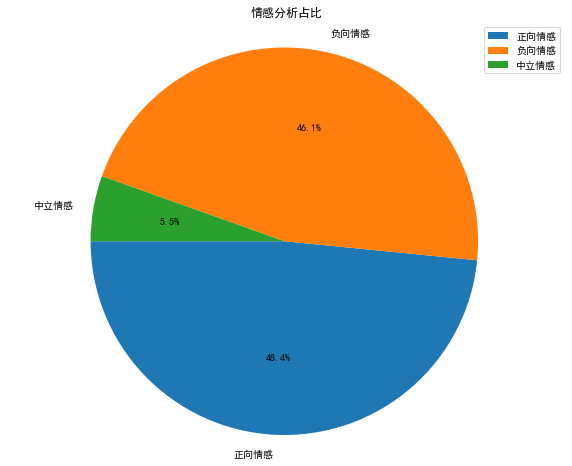

In [4]:
def plot_sentiment(df):
    data = df['情感倾向'].value_counts().to_dict()
    sentiment_map = {
        0: '正向情感',
        1: '中立情感',
        2: '负向情感',
    }
    values = data.values()
    labels = [sentiment_map[i] for i in data.keys()]
    plt.figure(figsize=(10, 8))
    plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=180)
    plt.axis('equal')
    plt.title('情感分析占比')
    plt.legend()
    plt.show()
    
plot_sentiment(df)

In [5]:
def clean_data(text):
    if not isinstance(text, str):
        return ""
    patterns = [
        '[\t\n\r\f]',
        '[a-zA-Z\d]',
        '[哈啊嘿]',
        '@.*? ',
        '#.*? ',
        '#.*?$',
        '(http|https|ftp)://((((25[0-5])|(2[0-4]\d)|(1\d{2})|([1-9]?\d)\.){3}((25[0-5])|(2[0-4]\d)|(1\d{2})|([1-9]?\d)))|(([\w-]+\.)+(net|com|org|gov|edu|mil|info|travel|pro|museum|biz|[a-z]{2})))(/[\w\-~#]+)*(/[\w-]+\.[\w]{2,4})?([\?=&%_]?[\w-]+)*',
    ]
    for pattern in patterns:
        pattern = re.compile(pattern)
        text = re.sub(pattern, ' ', text)
    return text.lower()

def split_text(text, stopwords):
    text = jieba.lcut(text)
    res = []
    for word in text:
        if len(word) > 1 and word not in stopwords:
            res.append(word)
    return res


def topic_analysis(tokens, n_components, top_n):
    contents = [' '.join(t) for t in tokens]
    tfidf = TfidfVectorizer()
    x = tfidf.fit_transform(contents)
    model = LatentDirichletAllocation(n_components=n_components, random_state=42)
    model.fit(x)
    if hasattr(tfidf, 'get_feature_names_out'):
        feature_names = tfidf.get_feature_names_out()
    else:
        feature_names = tfidf.get_feature_names()
    rows = []
    for topic in model.components_:
        topwords = [feature_names[i] for i in topic.argsort()[: -top_n - 1:-1]]
        rows.append(topwords)
    return rows

In [6]:
with open('data/stopwords.txt', 'r', encoding='utf-8') as f:
    stop_words = f.read().strip().split('\n')

stop_words.extend(['展开', '全文'])
stop_words = set(stop_words)


documents = df['text'].apply(clean_data)
documents = documents.apply(split_text, args=(stop_words,))

# documents = [i for j in documents.tolist() for i in j]

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\STUDYH~1\AppData\Local\Temp\jieba.cache
Loading model cost 0.568 seconds.
Prefix dict has been built succesfully.


In [7]:
topic_analysis(documents, 30, 5)

[['崩溃', '态度', '寒心', '令其', '三胎'],
 ['韩国', '我国', '性冷淡', '白开水', '碎石子'],
 ['新闻', '三年', '三胎', '干嘛', '连剖'],
 ['三胎', '年生', '人生', '好意思', '有限公司'],
 ['三胎', '四胎', '指标', '血战', '女孩'],
 ['天下父母', '柏和金', '上辈子', '冻死', '三胎'],
 ['三胎', '感觉', '加油', '奖励', '生活'],
 ['蜘蛛侠', '一套', '救救', '三胎', '虫虫'],
 ['儿子', '五年', '大佬', '奇才', '女人'],
 ['响应', '三胎', '政策', '女婴', '国家'],
 ['图片', '查看', '三胎', '科技', '试一试'],
 ['三胎', '网页', '链接', '气场', '碍国'],
 ['三胎', '毕业', '顾魏', '经营', '开放'],
 ['女士', '试管', '三胎', '移植', '成功'],
 ['三胎', '女权', '小长胎', '再生', '先给'],
 ['讨论', '回复', '月份', '难过', '太监'],
 ['万元', '三胎', '孩子', '有人', '二胎'],
 ['评论', '陈赫', '三胎', '配图', '频道'],
 ['三胎', '月经', '铃玲', '一年', '集美'],
 ['舞蹈', '老师', '孩子', '训练', '女士'],
 ['三胎', '孩子', '地狱', '二胎', '视频'],
 ['姐妹', '三胎', '产品', '豪克', '黑黑'],
 ['集美', '三胎', '职业', '光明', '团肖战'],
 ['三胎', '蔬菜', '出门', '玩家', '彩礼'],
 ['长势', '三胎', '争议', '日常', '双双'],
 ['宝妈', '三胎', '三个', '处女', '进过'],
 ['板凳', '睡觉', '洗衣服', '洗完', '凉水'],
 ['三胎', '想要', '要生', '堕胎', '欲望'],
 ['三胎', '我来', '鼓励', '祝福', '男性'],
 ['贺行', '况樱', '三胎', '试试', '二

In [16]:
documents = df[df['情感倾向'] == 0]['text'].apply(clean_data)
documents = documents.apply(split_text, args=(stop_words,))
topic_analysis(documents, 30, 5)

[['生育', '记忆', '孩子', '日本', '防脱'],
 ['连环计', '登记', '教材', '转基因', '生育'],
 ['感谢', '计划生育', '世纪', '日本', '美国'],
 ['生子', '生育', '单身', '锻炼', '公子'],
 ['生育', '顾云雪', '后遗症', '重视', '沈辞洲'],
 ['小说', '主角', '贺琛', '楚诗染', '生育'],
 ['生育', '大脑', '出手', '生育率', '代孕'],
 ['李某', '男方', '彩礼', '同居', '万元'],
 ['柔顺', '精油', '乳腺癌', '生育', '质地'],
 ['成果', '计划生育', '拖到', '当初', '卫生'],
 ['提升', '筷子', '干嘛', '不知', '生育'],
 ['简历', '网页', '链接', '人口', '实时'],
 ['情义', '丰县', '丈夫', '前女友', '法院'],
 ['娱乐圈', '指标', '算了', '高昊然', '国家'],
 ['美好', '孩子', '生育', '弟子', '保佑'],
 ['精油', '第二代', '护发', '生育', '欧莱雅'],
 ['感觉', '尼玛', '三胎', '美的', '沃趣'],
 ['员工', '补贴', '携程', '政策', '生育'],
 ['缺德', '别太', '生育能力', '行政', '管理'],
 ['韩国', '过程', '生育率', '孩子', '生育'],
 ['生育率', '提高', '育儿', '支持', '贡献'],
 ['生育', '四川', '新房', '购买', '达州市'],
 ['母亲', '说法', '称颂', '体面地', '总说'],
 ['夏然', '浅夏', '安然', '新闻网', '中国'],
 ['视频', '微博', '今日说法', '婚姻制度', '想到'],
 ['转发', '微博', '冬亚', '讲座', '生育'],
 ['修复', '超清小昕', '名存实亡', '傅寰', '黎鸢'],
 ['事件', '周期', '妈妈', '周内', '生育'],
 ['国家', '我要', '医保', '检测', '生育'],
 ['专项', '扣除

In [17]:
documents = df[df['情感倾向'] == 1]['text'].apply(clean_data)
documents = documents.apply(split_text, args=(stop_words,))
topic_analysis(documents, 30, 5)

[['女性', '地位', '避而', '社会', '不生'],
 ['词条', '讨论', '平安', '记录', '也许'],
 ['国外', '影响', '说话', '论文', '佩佩'],
 ['儿子', '王一博', '记忆', '男人', '确实'],
 ['大王', '巡山', '依旧', '复健', '多点'],
 ['结婚', '活着', '一窝', '更年期', '静静的'],
 ['理由', '孩子', '一点', '深圳', '轻判'],
 ['工具', '计生委', '回复', '生育', '日本'],
 ['姜兰枝', '钟泽川', '小说', '笔趣', '主角'],
 ['女性', '生育', '提倡', '尿道', '卵细胞'],
 ['解决方案', '应对', '性别', '人口', '男性'],
 ['小时', '喜悦', '闻霜', '冻卵', '繁衍'],
 ['卫生巾', '子宫', '职业赛', '还傲', '出题'],
 ['青春期', '方法', '子宫', '丁克', '本能'],
 ['缺德', '心茶', '清风', '功劳', '宇宙'],
 ['爱情', '自我', '父母', '师长', '将来'],
 ['违反', '超生', '技术', '为啥', '毛虫'],
 ['观点', '罢免', '子女', '分手', '总统'],
 ['年度', '三代', '试管', '孩子', '婚姻'],
 ['谢知州', '杨秀芸', '贺立维', '孟颖芝', '提高'],
 ['概念', '生育率', '假体', '死亡', '出人命'],
 ['举办', '讲座', '工作人员', '提升', '属实'],
 ['男性', '退休年龄', '福报', '女生', '感想'],
 ['来谈', '下头', '平等', '婚育', '跟上'],
 ['孩子', '不用', '一项', '反向', '工作'],
 ['生育率', '恐婚', '恐育', '本子', '着急'],
 ['拿来', '婚姻', '合作', '女人', '不愿生'],
 ['韩国', '欲望', '差异', '部门', '匹配'],
 ['繁殖', '孩子', '不蓝', '转不动', '生育'],
 ['生育', '四川', '专家'

In [18]:
documents = df[df['情感倾向'] == 2]['text'].apply(clean_data)
documents = documents.apply(split_text, args=(stop_words,))
topic_analysis(documents, 30, 5)

[['孩子', '生育', '沉重', '感受', '头衔'],
 ['赛博', '朋克', '下降', '商场', '垃圾'],
 ['侵犯', '丧失', '生育能力', '死亡威胁', '轮流'],
 ['生育', '生育率', '结婚', '禁止', '全国'],
 ['行业', '老公', '生育率', '不值钱', '生育'],
 ['生育', '堕胎', '女性', '老公', '风险'],
 ['挑拨', '打击', '无助', '喜欢', '单家独户'],
 ['上南大', '春晚', '很浓', '这破', '丰县'],
 ['孩子', '生育', '医生', '小王', '女人'],
 ['特征', '离谱', '生育', '失业', '生育率'],
 ['生育率', '新法', '新规', '生育', '事件'],
 ['卫生巾', '权在', '安妮', '罗洁', '女权'],
 ['生育', '女儿', '两个', '实施', '正式'],
 ['讲座', '生育', '贞洁', '举办', '生育权'],
 ['生育', '讨论', '网友', '遗产', '社会'],
 ['人民法庭', '周浦', '航头', '法官', '上海'],
 ['时节', '花开花落', '新闻频道', '广西', '生育'],
 ['发现自己', '生育能力', '生育', '铁链', '热点'],
 ['后遗症', '重视', '生育', '人类', '估计'],
 ['流狐婪', '逮人', '计划生育', '生育', '月子病'],
 ['生育率', '韩国', '下降', '原因', '太高'],
 ['价值', '生育', '孩子', '生育率', '打胎'],
 ['带薪', '两眼', '德国', '三十天', '法定标准'],
 ['生育', '纳入', '女性', '结婚', '选择'],
 ['不好', '孩子', '堕胎', '鲜红', '后背'],
 ['行天下', '面临', '师妹', '无情', '格格'],
 ['真实', '案例', '位多囊', '患者', '婚内'],
 ['人口', '狠狠', '没得', '女儿', '真的'],
 ['孩子', '根源', '生育', '女人', '鼓励'],
 ['生育',

In [16]:
df['date'] = df['date'].apply(lambda x: x[:4] + x[5:7])

In [ ]:
df.groupby('date').count()['text'].plot()